In [62]:
from typing import List
import numpy as np
import pandas as pd
from pynwb import NWBFile, TimeSeries
from pynwb.behavior import BehavioralEvents
from pynwb.file import Subject
from pynwb.ecephys import ElectrodeGroup
import nixio
import regex as re
from usz_neuro_conversion.common import (
    SessionContext,
    NixContext,
    get_metadata_row,
    read_nix,
    get_date,
    write_nwb,
    standardize_sex,
    find_nix_files,
)
import matplotlib.pyplot as plt
from usz_neuro_conversion.common import create_nwb_io_for_reading, NwbContext

In [2]:
context = NwbContext(subject=1, session=1, project="Human_MTL_units_visual_WM")
io = create_nwb_io_for_reading(context)
nwb = io.read()

In [18]:
units: pd.DataFrame = nwb.units.to_dataframe()

Text(0, 0.5, 'Unit 2')

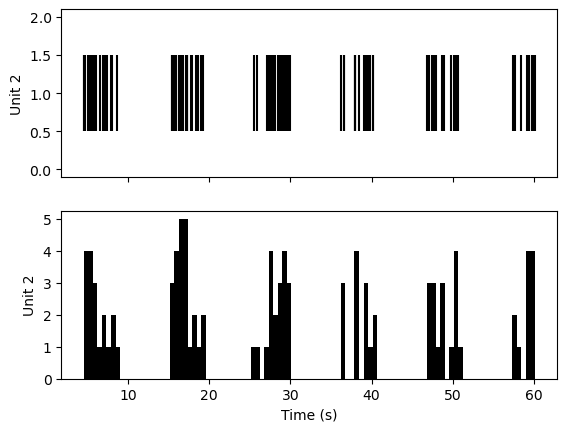

In [64]:
spikes = units["spike_times"][2][:100]
fig, ax = plt.subplots(2, 1, sharex="all")
plt.xlabel("Time (s)")
ax[0].eventplot(spikes, color="black")
ax[0].set_ylabel("Unit 2")

ax[1].hist(spikes, bins=100, color="black")
ax[1].set_ylabel("Unit 2")
